Loading train/test splits...
X_train shape: (3392, 15)
X_test shape: (848, 15)

Setting up Grid Search for LassoNet with class weighting...


Choosing lambda with cross-validation: 100%|██████████| 5/5 [00:33<00:00,  6.73s/it]



Best Parameters (cross-validation):
Best Lambda: 7.988801830877642
Best Cross-Validated F1-Score: 0.6751

Test Set Results:
Accuracy: 0.6627

Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.66      0.77       719
           1       0.26      0.68      0.38       129

    accuracy                           0.66       848
   macro avg       0.59      0.67      0.57       848
weighted avg       0.82      0.66      0.71       848



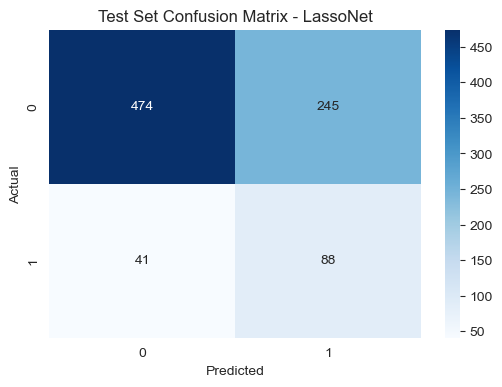

Selected Features: tensor([True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True])
Best LassoNet model with class weighting saved to ../models/lassonet_best_model_with_class_weight.pkl


In [4]:
# --- 03_lasso_net_classifier_with_class_weight.ipynb ---

import numpy as np
import pandas as pd
from lassonet import LassoNetClassifierCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import os
from sklearn.preprocessing import StandardScaler
from sklearn.utils import class_weight
import torch

# 1. Load preprocessed data
print("Loading train/test splits...")
X_train = np.load("../data/splits/X_train.npy")
y_train = np.load("../data/splits/y_train.npy")
X_test = np.load("../data/splits/X_test.npy")
y_test = np.load("../data/splits/y_test.npy")

# 2. Normalize the Data (if not done already)
#scaler = StandardScaler()
#X_train_scaled = scaler.fit_transform(X_train)
#X_test_scaled = scaler.transform(X_test)

print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}\n")

# ==============================
# Part 2: Compute Class Weights
# ==============================

# Compute class weights based on training data
class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)

# Convert class weights to a tensor
class_weights_tensor = torch.FloatTensor(class_weights).to(torch.device('cuda' if torch.cuda.is_available() else 'cpu'))

# ==============================
# Initialize and train the LassoNet model with class weighting
# ==============================

print("Setting up Grid Search for LassoNet with class weighting...")
model = LassoNetClassifierCV(class_weight=class_weights_tensor)  # Pass the computed class weights as tensor

# Fit the model with cross-validation on the training data
model.fit(X_train, y_train)

# Get the best lambda from cross-validation
print("\nBest Parameters (cross-validation):")
print(f"Best Lambda: {model.best_lambda_}")
print(f"Best Cross-Validated F1-Score: {model.best_cv_score_:.4f}\n")

# 3. Evaluate the best model on the test set
y_test_pred = model.predict(X_test)

print("Test Set Results:")
print(f"Accuracy: {accuracy_score(y_test, y_test_pred):.4f}")
print()
print("Classification Report:")
print(classification_report(y_test, y_test_pred))

# 4. Confusion Matrix for test set
cm = confusion_matrix(y_test, y_test_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Test Set Confusion Matrix - LassoNet")
plt.show()

# 5. Feature Importance
# Print out feature importance using the selected features (LassoNet's built-in feature selection)
selected_features = model.best_selected_
print(f"Selected Features: {selected_features}")

# 6. Save the best model to disk
os.makedirs("../models", exist_ok=True)
model_path = "../models/lassonet_best_model_with_class_weight.pkl"
joblib.dump(model, model_path)
print(f"Best LassoNet model with class weighting saved to {model_path}")

# 7. Save GridSearch Results (Optional)
# Note: Some LassoNet models may not expose `cv_results_`, so you may not be able to save them like scikit-learn.
# results_df = pd.DataFrame(model.cv_results_)
# results_df.to_csv("../results/lasso_gridsearch_results_class_weight.csv", index=False)
# print("Grid search results for class weighting saved to ../results/lasso_gridsearch_results_class_weight.csv")
